Notebook prepared by Mathieu Blondel and Pierre Ablin.

# Lecture 1

## Ridge regression

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Load the California housing dataset.
X_california, y_california = fetch_california_housing(return_X_y=True)

# Split into 60% training, 20% validation and 20% test.
X_california_tr, X_rest, y_california_tr, y_rest = \
  train_test_split(X_california, y_california, test_size=0.4, random_state=0)
X_california_val, X_california_te, y_california_val, y_california_te = \
  train_test_split(X_rest, y_rest, test_size=0.5, random_state=0)

**Exercise 1.** Implement the analytical solution of ridge regression $(X^\top X + \alpha I) w = X^\top y$ (see [slides](https://data-psl.github.io/lectures2022/slides/05_optimization_linear_models)) using [scipy.linalg.solve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html). Compute the solution on the training data. Make sure that the gradient at the solution is zero (up to machine precision).

In [2]:
import numpy as np
from scipy.linalg import solve

def ridge_regression_solution(X, y, alpha):
  n, p = X.shape
  I = np.identity(p)
  return solve(X.T.dot(X) + alpha * I, X.T.dot(y))

def ridge_regression_gradient(w, X, y, alpha):
  return -X.T.dot(y - X.dot(w)) + alpha * w

w_star = ridge_regression_solution(X_california_tr, y_california_tr, alpha=1)
print(w_star)
gradient = ridge_regression_gradient(w_star, X_california_tr, y_california_tr, alpha=1)
print("----------")
print(gradient)
np.sqrt(np.sum(gradient ** 2))

[ 5.26812332e-01  1.53579509e-02 -2.03258917e-01  8.78095315e-01
  3.41349170e-06 -4.98394658e-03 -6.02215402e-02 -1.58318140e-02]
----------
[ 5.35056444e-11  1.75879063e-09 -3.33927330e-13  1.13817844e-11
  3.46192959e-08  1.78449724e-10 -4.73148291e-10 -5.87154040e-09]


3.516138060474931e-08

**Exercise 2.** Train the models for several possible values of alpha (see below). Plot the mean squared error on the test set as a function of alpha. Use the validation data to find the best alpha and display it on the graph using a circle.

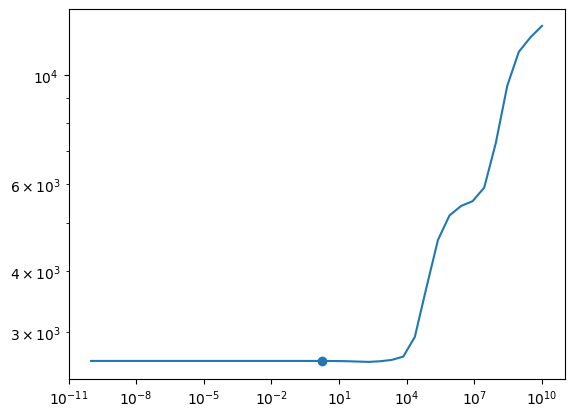

In [3]:
alphas = np.logspace(-10, 10, 40)

mse_val = []
mse_test = []
for alpha in alphas:
  w = ridge_regression_solution(X_california_tr, y_california_tr, alpha)
  mse_test.append(np.sum((X_california_te.dot(w) - y_california_te) ** 2))
  mse_val.append(np.sum((X_california_val.dot(w) - y_california_val) ** 2))

import matplotlib.pyplot as plt

i = np.argmin(mse_val)
plt.figure()
plt.loglog(alphas, mse_test)
plt.scatter(alphas[i], mse_test[i])
plt.show()


**Bonus exercise.** Implement a scikit-learn compatible estimator class (with fit and predict methods). Compare that you obtain the same results as `sklearn.linear_model.Ridge(fit_intercept=False)`.

In [4]:
from sklearn.base import BaseEstimator, RegressorMixin

class MyRidge(BaseEstimator, RegressorMixin):
  def __init__(self, alpha=1.0):
    self.alpha = alpha

  def fit(self, X, y):
    self.w_ = ridge_regression_solution(X, y, self.alpha)
    return self

  def predict(self, X):
    return X.dot(self.w_)

from sklearn.linear_model import Ridge

print(MyRidge().fit(X_california_tr, y_california_tr).predict(X_california_te)[:10])
print(Ridge(fit_intercept=False).fit(X_california_tr, y_california_tr).predict(X_california_te)[:10])

[2.26476736 2.04157803 1.91865531 1.27941599 1.65664333 4.08525141
 1.78386342 1.74617333 2.03092742 1.40476656]
[2.26476736 2.04157803 1.91865531 1.27941599 1.65664333 4.08525141
 1.78386342 1.74617333 2.03092742 1.40476656]


## Logistic regression

In [5]:
from sklearn.datasets import load_iris

X_iris, y_iris = load_iris(return_X_y=True)
# Keep only two classes for this exercise.
X_iris = X_iris[y_iris <= 1]
y_iris = y_iris[y_iris <= 1]

**Exercise 3.** Make a function that computes
$$
\text{softplus}(u) = \log(1 + e^u)
$$
and notice that its derivative is
$$
(\text{softplus}(u))' = \frac{e^u}{1 + e^u} = \frac{1}{1 + e^{-u}} = \text{sigmoid}(u).
$$
Using the finite difference formula $f'(u) \approx \frac{f(u + \epsilon) - f(u)}{\epsilon}$ where epsilon is small value (e.g. 10^-6), check that the derivative of softplus is indeed the sigmoid.

In [6]:
import numpy as np
from scipy.special import expit as sigmoid

def softplus(u):
  return np.log(1 + np.exp(u))

def finite_difference(f,u, epsilon=1e-6):
  return (f(u + epsilon) - f(u)) / epsilon

print(softplus(3))
print(finite_difference(softplus, 3))
print(sigmoid(3))

3.048587351573742
0.9525741493376927
0.9525741268224334


**Exercise 4.**
Make a function that computes the likelihood
$$
\text{likelihood}(u_i, y_i) = y_i \log \text{sigmoid}(u_i) + (1-y_i) \log (1-\text{sigmoid}(u_i))
$$
where $u_i = \mathbf{w}^\top \mathbf{x}_i$.
Using
$$
\log \text{sigmoid}(u) = -\text{softplus}(-u)
$$
and
$$
\log(1 - \text{sigmoid}(u)) = -\text{softplus}(u)
$$
make a function that computes the derivative of $\text{likelihood}(u_i, y_i)$ with respect to $u_i$. Check the result by finite difference. Be careful of signs!

In [7]:
def likelihood(u_i, y_i):
  return - y_i *  softplus(-u_i) - (1 - y_i) * softplus(u_i)

def likelihood_derivative(u_i, y_i):
  return y_i * sigmoid(-u_i) - (1 - y_i) * sigmoid(u_i)

def finite_difference(f,u, x, epsilon=1e-6):
  return (f(u + epsilon, x) - f(u, x)) / epsilon

print(likelihood_derivative(3, 1))
print(finite_difference(likelihood, 3, 1))

0.04742587317756678
0.04742585048983505


**Exercise 5.** Write a function that implements the penalized objective function
$$
L(\mathbf{w})
= -\sum_{i=1}^n y_i \log \text{sigmoid}(\mathbf{w}^\top \mathbf{x}_i) + (1-y_i) \log (1-\text{sigmoid}(\mathbf{w}^\top \mathbf{x}_i)) + \frac{\alpha}{2} \|\mathbf{w}\|^2
$$
and another function that computes its gradient. Reuse `likelihood(u_i, y_i)` and `likelihood_derivative(u_i, y_i)` (you can use a for loop). Check that the gradient is correct using finite differences.

In [8]:
def objective_value(w, X, y, alpha):
  l = 0
  for i in range(len(X)):
    l -= likelihood(w.dot(X[i]), y[i])
  l += 0.5 * alpha * np.sum(w **2)
  return l

def objective_gradient(w, X, y, alpha):
  g = np.zeros_like(w)
  for i in range(len(X)):
    g -= likelihood_derivative(w.dot(X[i]), y[i]) * X[i]
  g += alpha * w
  return g

def finite_difference_gradient(func, w, *args, eps=1e-6):
  gradient = np.zeros_like(w)
  for j in range(len(w)):
    e_j = np.zeros(len(w))
    e_j[j] = 1
    gradient[j] = (func(w + eps * e_j, *args) - func(w, *args)) / eps
  return gradient


n_samples, n_features = X_iris.shape
w = np.random.randn(n_features)
alpha = 0.1
print(objective_gradient(w, X_iris, y_iris, alpha))
print(finite_difference_gradient(objective_value, w, X_iris, y_iris, alpha))

[-279.061241   -127.15561717 -206.52414885  -65.03683602]
[-279.06119786 -127.15559936 -206.52414125  -65.03683539]


**Exercise 6.** Implement gradient descent. Check that the objective value is decreasing. Plot the objective value as a function of the number of iterations.

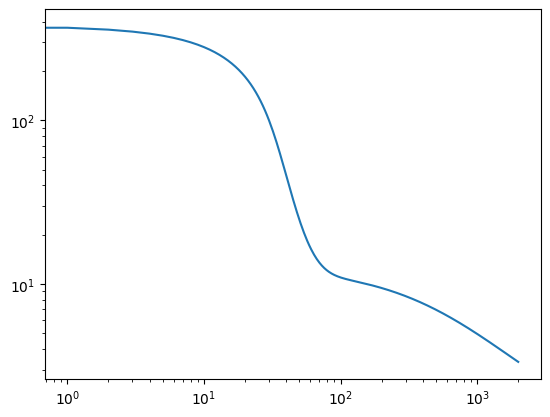

In [9]:
def gradient_descent(value_function, gradient_function, w_init, *args,
                     step_size=1e-4, num_iterations=2000):
  values = []
  w = np.copy(w_init)
  for i in range(num_iterations):
    w = w - step_size * gradient_function(w, *args)
    values.append(value_function(w, *args))
  # Write gradient descent iteration here.
  return values

n_samples, n_features = X_iris.shape
w_init = np.random.randn(n_features)
values = gradient_descent(objective_value, objective_gradient, w_init, X_iris, y_iris, alpha)

import matplotlib.pyplot as plt
plt.figure()
plt.loglog(np.arange(len(values)), values)
plt.show()

**Exercise 7.** Rewrite `objective_value` and `objective_gradient` without for loop. Check the correctness of your implementation against the version with a for loop.

In [10]:
def objective_value_no_loop(w, X, y, alpha):
  y_pred = np.dot(X, w)
  likelihoods = y * np.log(sigmoid(y_pred)) + (1 - y) * np.log(1 - sigmoid(y_pred))
  value = -likelihoods.sum()
  value += 0.5 * alpha * np.sum(w ** 2)
  return value

def objective_gradient_no_loop(w, X, y, alpha):
  y_pred = np.dot(X, w)
  likelihood_deriv = y * sigmoid(-y_pred) + (1 - y) * -sigmoid(y_pred)
  gradient = -np.dot(X.T, likelihood_deriv)
  gradient += alpha * w
  return gradient

n_samples, n_features = X_iris.shape
w = np.random.randn(n_features)
alpha = 0.1
print(objective_value(w, X_iris, y_iris, alpha))
print(objective_value_no_loop(w, X_iris, y_iris, alpha))
print(objective_gradient(w, X_iris, y_iris, alpha))
print(objective_gradient_no_loop(w, X_iris, y_iris, alpha))

213.1157800020467
213.11578000204676
[ 19.98951545  59.62350528 -87.80722284 -37.47473878]
[ 19.98951545  59.62350528 -87.80722284 -37.47473878]


Time the two implementations.

In [11]:
%time objective_value(w, X_iris, y_iris, alpha)

CPU times: user 1.05 ms, sys: 7 µs, total: 1.05 ms
Wall time: 1.06 ms


213.1157800020467

In [12]:
%time objective_value_no_loop(w, X_iris, y_iris, alpha)

CPU times: user 139 µs, sys: 20 µs, total: 159 µs
Wall time: 164 µs


213.11578000204676

# Lecture 2

# Stochastic gradient descent

We will focus on the California dataset and ridge regression. We will start by scaling the dataset

In [13]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X_california)
y = y_california - y_california.mean()
y /= np.std(y_california)

**Exercise 8.** Write a function that computes the stochastic gradient of ridge regression
$$
L(\mathbf{w}) = \frac{1}{n} \|\mathbf{y} - \mathbf{X} \mathbf{w}\|^2
+ \frac{\alpha}{2} \|\mathbf{w}\|^2
$$
(notice the 1/n factor).

Check that the mean of the stochastic gradients gives the gradient.

In [14]:
def ridge_objective(w, X, y, alpha):
    residual = y - np.dot(X, w)
    n_samples, n_features = X.shape
    return np.sum(residual ** 2) / n_samples + alpha * np.dot(w, w) / 2


def ridge_gradient(w, X, y, alpha):
    n_samples, n_features = X.shape
    return 2 * (np.dot(X, w) - y).dot(X) / n_samples + alpha * w


def stochastic_gradient(w, i, X, y, alpha):
  n_samples = len(X)
  gradient = np.zeros_like(w)
  gradient = 2 * (np.dot(X[i], w) - y[i]) * X[i]
  gradient += alpha * w
  return gradient


n_samples, n_features = X.shape
w = np.random.randn(n_features)
alpha = 0.1
print(np.mean([stochastic_gradient(w, i, X, y, alpha) for i in range(n_samples)], axis=0))
print(ridge_gradient(w, X, y, alpha))

[-0.40540193 -1.28751714  3.82491152  3.53280375 -2.21853168  1.15888479
  4.64262379 -3.82693893]
[-0.40540193 -1.28751714  3.82491152  3.53280375 -2.21853168  1.15888479
  4.64262379 -3.82693893]


**Exercise 9.** Write a function that implements stochastic gradient descent. Implement two rules for sampling the index: cyclic, and at random. Compare the convergence of both algorithms. What is the role of the step size?

You should especially look at the convergence speed and the value at which the algorithm plateaus.

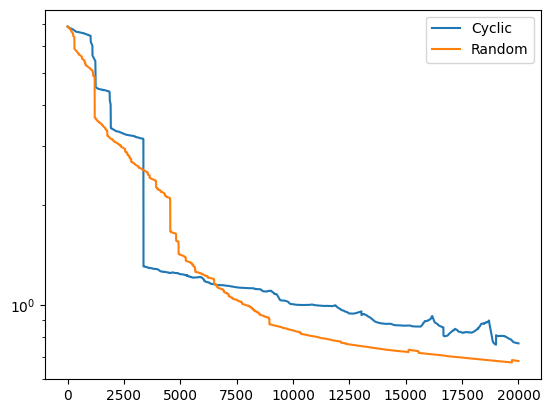

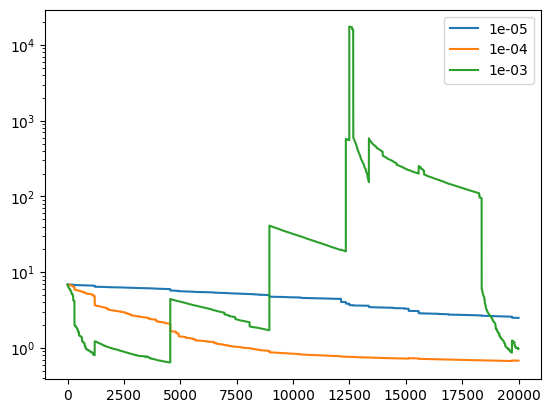

In [15]:
def stochastic_gradient_descent(value_function, gradient_function, w_init, idx_list, *args,
                                step_size=1e-4, num_iterations=1000):
  values = []
  w = np.copy(w_init)
  for i in range(num_iterations):
    idx = idx_list[i]
    w = w - step_size * gradient_function(w, idx, *args)
    values.append(value_function(w, *args))
  return values

w = np.random.randn(n_features)
num_iterations = 20000
step_size = 1e-4
idx_cyclic = np.arange(num_iterations) % n_samples
values_cyclic = stochastic_gradient_descent(ridge_objective,
                                            stochastic_gradient,
                                            w, idx_cyclic, X,
                                            y, alpha, step_size=step_size,
                                            num_iterations=num_iterations)
idx_random = np.random.randint(0, n_samples, num_iterations)
values_random = stochastic_gradient_descent(ridge_objective,
                                            stochastic_gradient,
                                            w, idx_random, X,
                                            y, alpha, step_size=step_size,
                                            num_iterations=num_iterations)
plt.figure()
plt.plot(np.arange(len(values_cyclic)), values_cyclic, label='Cyclic')
plt.plot(np.arange(len(values_random)), values_random, label='Random')
plt.legend()
plt.yscale('log')
plt.show()

plt.figure()

for step_size in [1e-5, 1e-4, 1e-3]:
    values = stochastic_gradient_descent(ridge_objective,
                                         stochastic_gradient,
                                         w, idx_random, X,
                                         y, alpha, step_size=step_size,
                                         num_iterations=num_iterations)
    plt.plot(values, label='%.e' % step_size)
plt.legend()
plt.yscale('log')
plt.show()



# L-BFGS

L-BFGS is the go-to second order method. It is already implemented in `scipy`:

In [16]:
from scipy.optimize import fmin_l_bfgs_b

**Exercise 10.** Use the L-BFGS code to optimize the logistic regression on the Iris dataset. Compare it with your gradient descent.

Hint: in order to store the function values, you can use the callback function in `fmin_l_bfgs_b`. Don't forget to read the documentation !

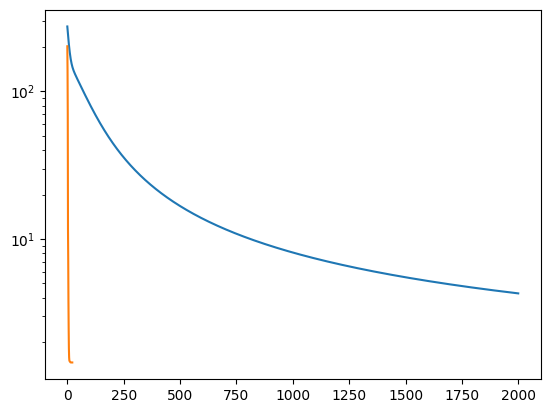

In [17]:
class callback(object):
    def __init__(self):
        self.values = []

    def __call__(self, w):
        self.values.append(objective_value_no_loop(w, X_iris, y_iris, alpha))


n_samples, n_features = X_iris.shape
w_init = np.random.randn(n_features)
values = gradient_descent(objective_value, objective_gradient, w_init, X_iris, y_iris, alpha)

cb = callback()
_ = fmin_l_bfgs_b(objective_value, w_init, objective_gradient, args=(X_iris, y_iris, alpha), callback=cb)
plt.figure()
plt.plot(np.arange(len(values)), values)
plt.plot(cb.values)
plt.yscale('log')
plt.show()
